# HW9: CNN
## 2022104346 정지헌

필요한 모듈 불러오기

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal, Iterable

transform 및 상수 정의

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
LR = 1e-3
EPOCH = 128
BATCH_SIZE = 32
DATA_PATH = "./cifar10"

데이터셋 불러오기 및 dataloader 객체 생성

In [3]:
cifar_10_training = datasets.CIFAR10(DATA_PATH, train = True, transform = transform, download = True)
cifar_10_validation = datasets.CIFAR10(DATA_PATH, train = False, transform = transform, download = False)

Files already downloaded and verified


In [4]:
training_data_loader = DataLoader(cifar_10_training,
                                  batch_size = BATCH_SIZE,
                                  shuffle = True)
validation_data_loader = DataLoader(cifar_10_validation, 
                                    batch_size = 10000,
                                    shuffle = False)

모델, Trainer 클래스 정의

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # input: (N, 3, 32, 32)
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 2) # (N, 32, 32, 32)
        self.relu1 = nn.ReLU() # (N, 32, 32, 32)

        self.pool1 = nn.MaxPool2d(2) # (N, 32, 16, 16)

        self.conv2 = nn.Conv2d(32, 32, 5, padding = 2) # (N, 32, 16, 16)
        self.relu2 = nn.ReLU() # (N, 32, 16, 16)

        self.pool2 = nn.MaxPool2d(2) # (N, 32, 8, 8)

        self.conv3 = nn.Conv2d(32, 64, 5, padding = 2) # (N, 64, 8, 8)
        self.relu3 = nn.ReLU() # (N, 64, 8, 8)

        self.pool3 = nn.MaxPool2d(2) # (N, 64, 4, 4)

        self.flatten = nn.Flatten() # (N, 1024)

        self.lin1 = nn.Linear(1024, 1024) # (N, 1024)
        self.relu4 = nn.ReLU()

        self.lin2 = nn.Linear(1024, 10) # (N, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.lin1(x)
        x = self.relu4(x)
        x = self.lin2(x)

        return x

class Trainer:
    def __init__(self, data_loader: DataLoader, validation_data_loader: DataLoader, model: Model, loss_fn: nn.Module, device: Literal["cpu", "cuda"], epoch: int, lr: float):
        self.device = device
        self.lr = lr
        self.epoch = epoch
        self.data_loader = data_loader
        self.validation_data_loader = validation_data_loader
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.loss_fn = loss_fn

        self.min_mean_loss = 1e45
        self.min_mean_loss_model = None

    def validate(self, accuracy_mode: bool = False): 
        with torch.no_grad():
            for sample in self.validation_data_loader:
                input_data, ans = sample[0].to(self.device), sample[1].to(self.device)
                model_output = self.model.forward(input_data)

                if accuracy_mode:
                    model_output_argmax = torch.argmax(model_output, dim = 1).numpy(force = True)
                    ans = ans.numpy(force = True)
                    correct = []

                    for i in range(10000):
                        if np.isclose(ans[i], model_output_argmax[i]):
                            correct.append(1.1)
                        else:
                            correct.append(0.0)
                    
                    return float(np.mean(correct))
                
                else:
                    loss = self.loss_fn.forward(input = model_output, target = ans)
                    return float(loss)
        
    def train(self):

        for _ in range(self.epoch):
            
            for sample in self.data_loader:

                input_data, ans = sample[0].to(self.device), sample[1].to(self.device)
                model_output = self.model.forward(input_data)
                loss = self.loss_fn.forward(input = model_output, target = ans)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            validation_loss = self.validate()
            if validation_loss < self.min_mean_loss:
                self.min_mean_loss = validation_loss
                self.min_mean_loss_model = self.model.state_dict()
        
        self.model.load_state_dict(self.min_mean_loss_model)
        return self.model
    
    def show_example(self):
        with torch.no_grad():
            for sample in self.validation_data_loader:
                input_data, ans = sample[0].to(self.device), sample[1].numpy(force = True)
                model_output_argmax = torch.argmax(self.model.forward(input_data), dim = 1).numpy(force = True)
                random_idx = np.random.randint(0, 9999)
                img = input_data[random_idx, :, :, :].permute(1, 2, 0).numpy(force = True)

                plt.imshow(img, cmap = 'brg')
                print("model_output:", model_output_argmax[random_idx])
                print("ans:", ans[random_idx])

학습

In [6]:
trainer = Trainer(data_loader = training_data_loader,
                  validation_data_loader = validation_data_loader,
                  model = Model(),
                  loss_fn = nn.CrossEntropyLoss(),
                  device = DEVICE,
                  epoch = EPOCH,
                  lr = LR)

In [7]:
trained_model = trainer.train()

모델 정확도 출력

In [8]:
model_accuracy = trainer.validate(accuracy_mode = True)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.7821


예시

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


model_output: 8
ans: 8


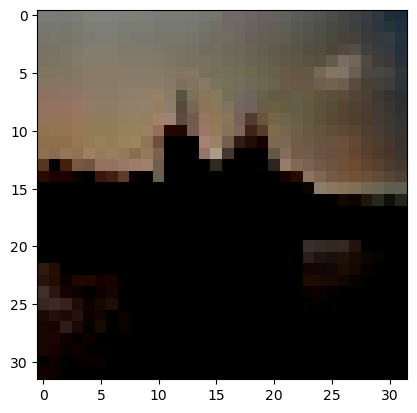

In [10]:
trainer.show_example()